# Chapter 8

In [1]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize
# Numba
from numba import jit, f8


set the random seed

For some experiment, we need to compare numeric solution and exact solution, then we need to set the seed. Otherwise set `seed = None`

In [2]:
seed = 42

In [3]:
def EulerMaruyama(u0, T, N, d, m, f, G):
    '''
    u0: inital u(0)
    u:d-dim
    W:m-dim
    N: number of time interval
    '''
    dt = T / N
    u = np.zeros((d, N+1))
    t = np.linspace(0, T, N+1)
    u_n = np.copy(u0)
    u[:,0] = u_n
    np.random.seed(seed)
    for n in range(N):
        dW = sqrt(dt) * np.random.randn(m)
        u_n = u_n + f(u_n)*dt + np.dot(G(u_n), dW)
        u[:, n+1] = u_n
    return t, u

E.g.1 Ornstein-Uhlenbeck process

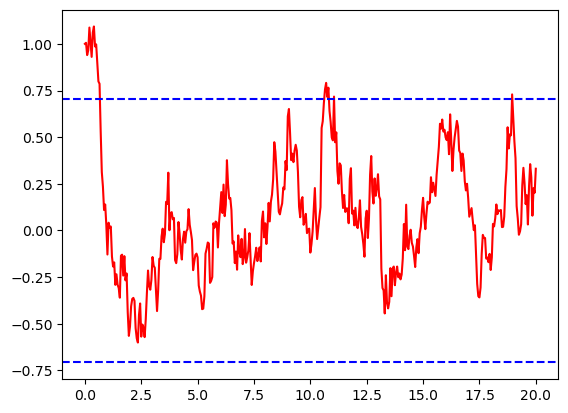

In [4]:
def OrnUhl(u0, T, N, lam, sigma):
    t, u = EulerMaruyama(u0, T, N, 1, 1, lambda u: -lam * u, lambda u: sigma)
    return t, u

lam=1; sigma=0.5
u0=np.array([1])
dt = 0.05
T=20
N=int(T/dt)
[t,u]=OrnUhl(u0,T,N,lam,sigma)
plt.plot(t, u[0,:], color='red', label='P') 
plt.axhline(y=2*sqrt(sigma**2/(2*lam)), color='blue', linestyle='--', label='90%')
plt.axhline(y=-2*sqrt(sigma**2/(2*lam)), color='blue', linestyle='--', label='90%')

E.g.2 Duffing -van der Pol equation
[Q
P]

In [5]:
@jit
def vanderpol_f(u, lam, alpha):
    Q = u[0]; P = u[1]
    f = np.array([P, -P*(lam + Q**2)+alpha*Q-Q**3])
    return f

@jit
def vanderpol_G(u, sigma):
    Q = u[0]; P = u[1]
    G = np.array([0, sigma * Q])
    G = G.reshape(-1,1)
    return G

def vanderpol(u0, T, N, lam, alpha, sigma):
    t,u = EulerMaruyama(u0, T, N, 2, 1, lambda u: vanderpol_f(u, lam, alpha), lambda u: vanderpol_G(u, sigma))
    return t, u


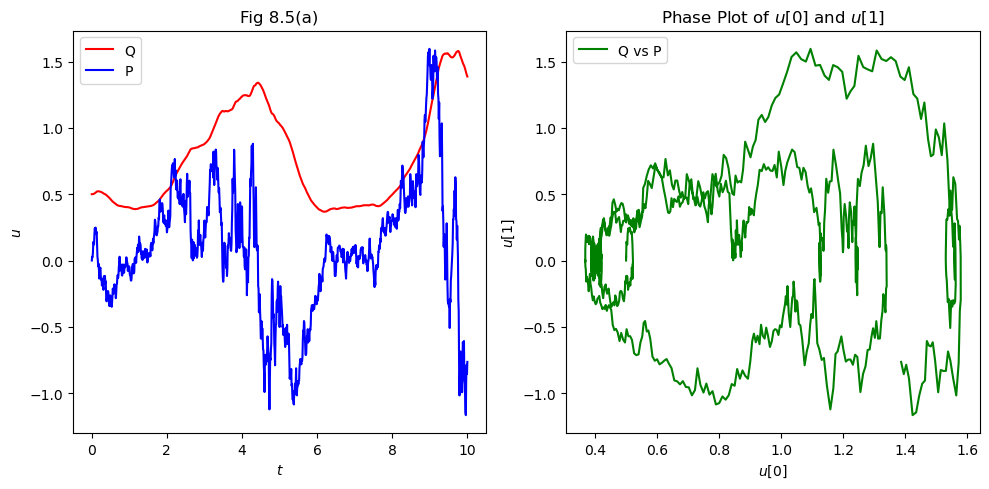

In [6]:
lam=1; alpha=1; sigma=1;
u0=np.array([0.5, 0])
T=10
N=1000
[t,u]=vanderpol(u0,T,N,alpha,lam,sigma)
#
plt.figure(figsize=(10, 5))

# 左侧的第一个子图
plt.subplot(1, 2, 1)
plt.plot(t, u[0, :], color='red', label='Q') 
plt.plot(t, u[1, :], color='blue', label='P') 
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.title(r'Fig 8.5(a)')
plt.legend()

# 右侧的第二个子图
plt.subplot(1, 2, 2)
plt.plot(u[0, :], u[1, :], color='green', label=r'Q vs P')
plt.xlabel(r'$u[0]$')
plt.ylabel(r'$u[1]$')
plt.title(r'Phase Plot of $u[0]$ and $u[1]$')
plt.legend()

plt.tight_layout()
plt.show()


E.g.3 Geometric Brownian Motion

In [7]:
import scipy.optimize
def EulerMaruyamaTheta(u0, T, N, d, m, f, G, theta):
    '''
    u0: inital u(0)
    u:d-dim
    W:m-dim
    N: number of time interval
    '''
    dt = T / N
    u = np.zeros((d, N+1))
    t = np.linspace(0, T, N+1)
    u_n = np.copy(u0)
    u[:,0] = u_n
    np.random.seed(seed)
    for n in range(N):
        dW = sqrt(dt) * np.random.randn(m)
        u_init=u_n + dt * f(u_n) + np.dot(G(u_n), dW)
        u_n = scipy.optimize.fsolve(lambda u: -u + u_n + (1-theta)*dt*f(u_n)+theta*dt*f(u)+np.dot(G(u_n), dW), u_init)
        u[:, n+1] = u_n
    return t, u

def GBM(u0, T, N, r, sigma):
    t, u = EulerMaruyama(u0, T, N, 1, 1, lambda u: r * u, lambda u: sigma * u)
    return t, u

def GBM_exact(u0, T, N, d, m, r, sigma):
    np.random.seed(seed)
    dt = T / N
    u = np.zeros((d, N+1))
    t = np.linspace(0, T, N+1)
    u[:,0] = u0
    W = 0
    for n in range(N):
        W = W + sqrt(dt) * np.random.randn(m)
        u[:, n+1] = np.exp((r-sigma**2/2)*t[n]+sigma*W)*u0
    return t, u

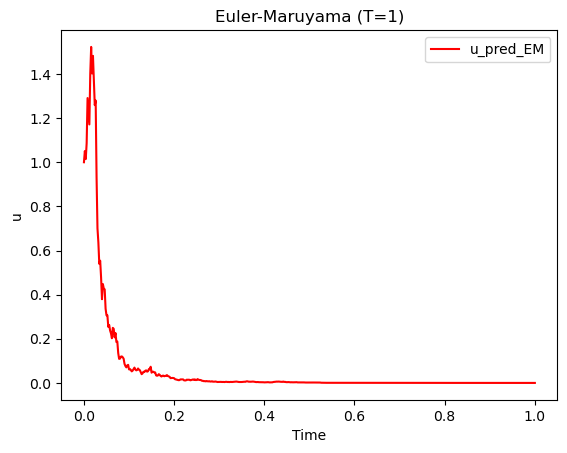

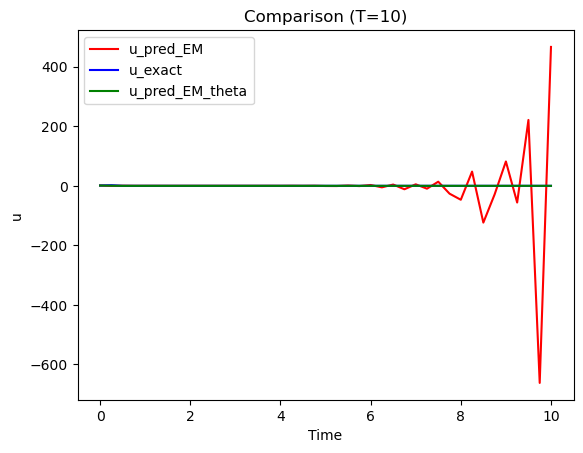

In [10]:
r=-8; sigma=3
u0=np.array([1])
#
T = 1
N = 500
[t, u] = EulerMaruyama(u0, T, N, 1, 1, lambda u: r * u, lambda u: sigma * u)

plt.figure()  
plt.plot(t, u[0, :], color='red', label='u_pred_EM')
plt.title("Euler-Maruyama (T=1)")
plt.xlabel("Time")
plt.ylabel("u")
plt.legend()

# 图2：T = 10, dt = 0.25
T = 10
dt = 0.25
N = int(T / dt)
[t, u] = EulerMaruyama(u0, T, N, 1, 1, lambda u: r * u, lambda u: sigma * u)
[t1, u_exact] = GBM_exact(u0, T, N, 1, 1, r, sigma)
[t2, u2] = EulerMaruyamaTheta(u0, T, N, 1, 1, lambda u: r * u, lambda u: sigma * u, theta=0.5)

plt.figure()  
plt.plot(t, u[0, :], color='red', label='u_pred_EM')
plt.plot(t1, u_exact[0, :], color='blue', label='u_exact')
plt.plot(t2, u2[0, :], color='green', label='u_pred_EM_theta')
plt.title("Comparison (T=10)")
plt.xlabel("Time")
plt.ylabel("u")
plt.legend()

plt.show()

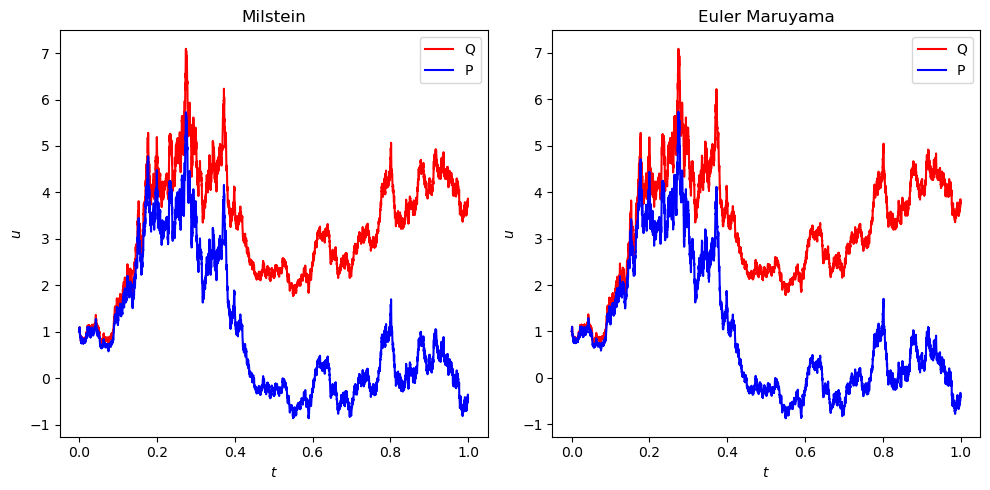

In [80]:
def MilsteinDiag(u0, T, N, d, m, f, G, dG):
    dt = T / N
    u = np.zeros((d, N+1))
    t = np.linspace(0, T, N+1)
    u_n = np.copy(u0)
    u[:,0] = u_n
    np.random.seed(seed)
    for n in range(N):
        dW = sqrt(dt) * np.random.randn(m)
        u_n = u_n + f(u_n)*dt + np.dot(G(u_n), dW) + 0.5 * (dG(u_n)*G(u_n)*(dW**2 - dt))
        u[:, n+1] = u_n
    return t, u

d=2; m=2;
A=np.array([[1,0],[0,-1]])
sigma=np.array([1,2])
T=1; N=5000;u0=np.array([1,1])
t1,u1 = MilsteinDiag(u0,T,N,d,m,
                lambda u: A.dot(u),
                lambda u: sigma*u,
                lambda u: sigma)

t2,u2 = EulerMaruyama(u0,T,N,d,m,
                lambda u: A.dot(u),
                lambda u: sigma*u)

plt.figure(figsize=(10, 5))

# 左侧的第一个子图
plt.subplot(1, 2, 1)
plt.plot(t1, u1[0, :], color='red', label='Q') 
plt.plot(t1, u1[1, :], color='blue', label='P') 
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.title(r'Milstein')
plt.legend()

# 右侧的第二个子图
plt.subplot(1, 2, 2)
plt.plot(t2, u2[0, :], color='red', label='Q') 
plt.plot(t2, u2[1, :], color='blue', label='P') 
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.title(r'Euler Maruyama')
plt.legend()

plt.tight_layout()
plt.show()

Consider the convergence

In [46]:
def EMpath(u0, T, Nref, d, m, f, G, k, M):
    dtref = T/Nref # fine
    dt = k * dtref # coarse
    N = Nref // k
    u = np.zeros((d, M, N+1))
    t = np.linspace(0, T, N)
    GdW = np.zeros((d, M))
    u_n = np.copy(u0)
    u[:, :, 0] = u0
    for n in range(N):
        np.random.seed(None)
        dW = sqrt(dtref)*np.sum(np.random.randn(k, m, M), axis=0)
        for i in range(M):
            GdW[:, i] = np.dot(G(u_n[:, i]), dW[:, i])
        u_n = u_n + dt * f(u_n) + GdW
        u[:,:,n+1] = u_n
    return t, u

def runEMpath(u0, T, Nref, d, m, f, G, k, M):
    Mstep = 100
    S = 0
    # split the samples to batches
    for mm in range(0, M, Mstep):
        u0_mm = u0[:, mm:mm+Mstep]
        _, uref = EMpath(u0_mm, T, Nref, d, m, f, G, 1, Mstep)
        _, u = EMpath(u0_mm, T, Nref, d, m, f, G, k, Mstep)
        err=u[:,:,-1] - uref[:,:,-1]
        S=S + np.linalg.norm(err,'fro')**2
    Err = sqrt(S/M)
    return Err

In [49]:
d=2; m=2; T=1; Nref=5000; Dtref=T/N; M=500
A=np.array([[1,0],[0,-1]])
u0=np.matlib.repmat(np.array([1,1]),M,1).T
  
kappa=np.array([5,10,50,100,500,1000],dtype='int32')
Err=np.zeros(kappa.shape)
for k in range(kappa.size):
    Err[k] = runEMpath(u0, T, Nref, d, m, lambda u: A.dot(u), lambda u: np.array([[u[0],0],[0,2*u[1]]]), kappa[k], M)

[4.85842492 5.37445973 5.90156457 5.82573606 4.95626561 5.16831321]


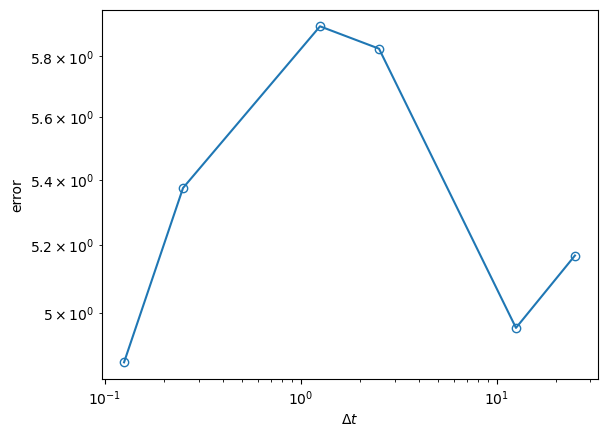

In [50]:
print(Err)
plt.loglog(Dtref*kappa,Err,'-o',fillstyle='none')
s=plt.xlabel(r'$\Delta t$')
s=plt.ylabel(r'error')